本章介绍如何使用 TensorFlow 快速搭建动态模型。

模型的构建： tf.keras.Model 和 tf.keras.layers

模型的损失函数： tf.keras.losses

模型的优化器： tf.keras.optimizer

模型的评估： tf.keras.metrics

https://tf.wiki/zh_hans/basic/models.html#mlp

## 模型和层 model & layer

在TensorFlow中，推荐使用tf.keras 构建模型

keras 有两个重要概念：
模型和层

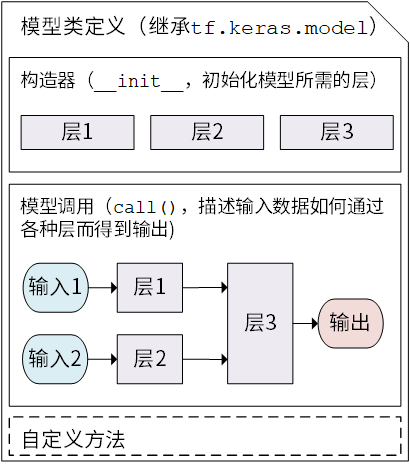

层将各种计算流程和变量进行了封装（例如基本的全连接层，CNN 的卷积层、池化层等）;

而模型则将各种层进行组织和连接，并封装成一个整体，描述了如何将输入数据通过各种层以及运算而得到输出。


In [ ]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super().__init__()     # Python 2 下使用 super(MyModel, self).__init__()
        # 此处添加初始化代码（包含 call 方法中会用到的层），例如
        # layer1 = tf.keras.layers.BuiltInLayer(...)
        # layer2 = MyCustomLayer(...)

    def call(self, input):
        # 此处添加模型调用的代码（处理输入并返回输出），例如
        # x = layer1(input)
        # output = layer2(x)
        return output

    # 还可以添加自定义的方法

- 对于上一章的简单线性模型，y_pred=a*X+b ,可以通过模型类的方式编写如下：

>注意，最大的区别是
这里，我们没有显式地声明 a 和 b 两个变量并写出 y_pred = a * X + b 这一线性变换，
而是建立了一个继承了 tf.keras.Model 的模型类 Linear 。
这个类在初始化部分实例化了一个 全连接层 （ tf.keras.layers.Dense ），并在 call 方法中对这个层进行调用，实现了线性变换的计算。

In [2]:
import tensorflow as tf

X = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
y = tf.constant([[10.0], [20.0]])


class Linear(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.dense = tf.keras.layers.Dense(
            units=1,  # 输出张量的维度
            activation=None,  # 激活函数
            kernel_initializer=tf.zeros_initializer(),  # 变量，对应于a
            bias_initializer=tf.zeros_initializer()   # 变量, 偏置向量，对应于b
        )

    def call(self, input):
        output = self.dense(input)
        return output


# 以下代码结构与前节类似
model = Linear()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
for i in range(100):
    with tf.GradientTape() as tape:
        y_pred = model(X)      # 调用模型 y_pred = model(X) 而不是显式写出 y_pred = a * X + b
        loss = tf.reduce_mean(tf.square(y_pred - y))
    grads = tape.gradient(loss, model.variables)    # 使用 model.variables 这一属性直接获得模型中的所有变量
    optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))
print(model.variables)

[<tf.Variable 'linear_1/dense_1/kernel:0' shape=(3, 1) dtype=float32, numpy=
array([[0.40784496],
       [1.191065  ],
       [1.9742855 ]], dtype=float32)>, <tf.Variable 'linear_1/dense_1/bias:0' shape=(1,) dtype=float32, numpy=array([0.78322077], dtype=float32)>]



**全连接层 （Fully-connected Layer，tf.keras.layers.Dense ）**

是 Keras 中最基础和常用的层之一，对输入矩阵 A 进行 f(AW + b) 的线性变换 + 激活函数操作。

如果不指定激活函数，即是纯粹的线性变换 AW + b

图例：

![image.png](https://tva1.sinaimg.cn/large/008i3skNgy1gsrylff3dvj31m00gu0v4.jpg)

## 多层感知机
在这一部分，我们依次进行以下步骤：

使用 tf.keras.datasets 获得数据集并预处理

使用 tf.keras.Model 和 tf.keras.layers 构建模型

构建模型训练流程，使用 tf.keras.losses 计算损失函数，并使用 tf.keras.optimizer 优化模型

构建模型评估流程，使用 tf.keras.metrics 计算评估指标

### 数据展示

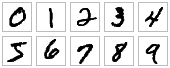

<class 'numpy.ndarray'> (60000, 28, 28)
2 (28, 28) uint8


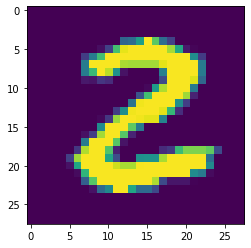

In [95]:
import matplotlib.pyplot as pyplot

(train_data, train_label), (test_data, test_label) = mnist.load_data()
print(type(train_data), train_data.shape)
i = 25
tmp = train_data[i]
print(train_label[i], tmp.shape, tmp.dtype)

pyplot.imshow(tmp)
pyplot.show()

In [113]:
# 维度扩展
train_data_tmp = np.expand_dims(tmp / 255.0, axis=-1)      # [60000, 28, 28, 1]
train_data_tmp.shape


(28, 28, 1)

In [118]:
# 数据获取
import numpy as np

class MNISTLoader():
    def __init__(self):
        mnist = tf.keras.datasets.mnist
        (self.train_data, self.train_label), (self.test_data, self.test_label) = mnist.load_data()
        # MNIST中的图像默认为uint8（0-255的数字）。以下代码将其归一化到0-1之间的浮点数，并在最后增加一维作为颜色通道
        self.train_data = np.expand_dims(self.train_data.astype(np.float32) / 255.0, axis=-1)      # [60000, 28, 28, 1]
        self.test_data = np.expand_dims(self.test_data.astype(np.float32) / 255.0, axis=-1)        # [10000, 28, 28, 1]
        self.train_label = self.train_label.astype(np.int32)    # [60000]
        self.test_label = self.test_label.astype(np.int32)      # [10000]
        self.num_train_data, self.num_test_data = self.train_data.shape[0], self.test_data.shape[0]

    def get_batch(self, batch_size):
        # 从数据集中随机取出batch_size个元素并返回
        index = np.random.randint(0, self.num_train_data, batch_size)
        return self.train_data[index, :], self.train_label[index]

### 模型构建
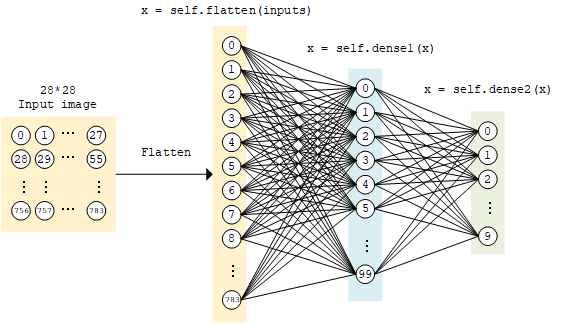

In [119]:
class MLP(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.flatten = tf.keras.layers.Flatten()    # Flatten层将除第一维（batch_size）以外的维度展平
        self.dense1 = tf.keras.layers.Dense(units=100, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(units=10)

    def call(self, inputs):         # [batch_size, 28, 28, 1]
        x = self.flatten(inputs)    # [batch_size, 784]
        x = self.dense1(x)          # [batch_size, 100]
        x = self.dense2(x)          # [batch_size, 10]
        output = tf.nn.softmax(x)
        return output

### 模型训练

In [120]:
# 定义超参数：
num_epochs=5
batch_size=50  # 每批次取50
learning_rate=0.01

# 实例化模型
model=MLP()
data_loader=MNISTLoader()
optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)


# 然后迭代进行以下步骤：
    # 1从 DataLoader 中随机取一批训练数据；
num_batches=int(data_loader.num_train_data //batch_size*num_epochs)
for batch_index in range(num_batches):
    X,y = data_loader.get_batch(batch_size)
    # 2. 将这批数据送入模型，计算出模型的预测值；
    with tf.GradientTape() as tape:
        y_pred = model(X)
        # 3.将模型预测值与真实值进行比较，计算损失函数（loss）。这里使用 tf.keras.losses 中的交叉熵函数作为损失函数；
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true=y, y_pred=y_pred)
        loss = tf.reduce_mean(loss)
        print("batch %d: loss %f" % (batch_index, loss.numpy()))
    # 4. 计算损失函数关于模型变量的导数；
    grads = tape.gradient(loss, model.variables)
    # 5. 将求出的导数值传入优化器，使用优化器的 apply_gradients 方法更新模型参数以最小化损失函数（优化器的详细使用方法见 前章 ）。    
    optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))



batch 0: loss 2.369420
batch 1: loss 2.012990
batch 2: loss 1.738612
batch 3: loss 1.514885
batch 4: loss 1.124558
batch 5: loss 1.295353
batch 6: loss 0.937894
batch 7: loss 0.924236
batch 8: loss 0.895333
batch 9: loss 1.076113
batch 10: loss 0.758249
batch 11: loss 0.654902
batch 12: loss 0.396772
batch 13: loss 0.395466
batch 14: loss 0.724253
batch 15: loss 0.502966
batch 16: loss 0.834559
batch 17: loss 0.522555
batch 18: loss 0.409965
batch 19: loss 0.376164
batch 20: loss 0.472839
batch 21: loss 0.452716
batch 22: loss 0.413694
batch 23: loss 0.506678
batch 24: loss 0.283379
batch 25: loss 0.243936
batch 26: loss 0.404322
batch 27: loss 0.607876
batch 28: loss 0.255558
batch 29: loss 0.570363
batch 30: loss 0.438070
batch 31: loss 0.116984
batch 32: loss 0.686662
batch 33: loss 0.396839
batch 34: loss 0.466518
batch 35: loss 0.428272
batch 36: loss 0.252954
batch 37: loss 0.500761
batch 38: loss 0.783210
batch 39: loss 0.598070
batch 40: loss 0.404697
batch 41: loss 0.247450
ba

batch 351: loss 0.409606
batch 352: loss 0.080214
batch 353: loss 0.081666
batch 354: loss 0.138626
batch 355: loss 0.114457
batch 356: loss 0.254106
batch 357: loss 0.098461
batch 358: loss 0.353893
batch 359: loss 0.112132
batch 360: loss 0.607410
batch 361: loss 0.201125
batch 362: loss 0.072301
batch 363: loss 0.254118
batch 364: loss 0.211971
batch 365: loss 0.150580
batch 366: loss 0.211620
batch 367: loss 0.286943
batch 368: loss 0.091387
batch 369: loss 0.624832
batch 370: loss 0.152262
batch 371: loss 0.101949
batch 372: loss 0.236156
batch 373: loss 0.202395
batch 374: loss 0.327984
batch 375: loss 0.204464
batch 376: loss 0.158700
batch 377: loss 0.068825
batch 378: loss 0.114786
batch 379: loss 0.223914
batch 380: loss 0.171762
batch 381: loss 0.404054
batch 382: loss 0.055138
batch 383: loss 0.029824
batch 384: loss 0.321301
batch 385: loss 0.231508
batch 386: loss 0.229537
batch 387: loss 0.177671
batch 388: loss 0.053190
batch 389: loss 0.249459
batch 390: loss 0.238148


batch 693: loss 0.233741
batch 694: loss 0.184788
batch 695: loss 0.156505
batch 696: loss 0.087153
batch 697: loss 0.125051
batch 698: loss 0.089241
batch 699: loss 0.215997
batch 700: loss 0.183916
batch 701: loss 0.135738
batch 702: loss 0.468021
batch 703: loss 0.341670
batch 704: loss 0.092604
batch 705: loss 0.115976
batch 706: loss 0.236527
batch 707: loss 0.159019
batch 708: loss 0.062713
batch 709: loss 0.110559
batch 710: loss 0.276635
batch 711: loss 0.072055
batch 712: loss 0.201698
batch 713: loss 0.154168
batch 714: loss 0.279315
batch 715: loss 0.080318
batch 716: loss 0.176379
batch 717: loss 0.045248
batch 718: loss 0.080245
batch 719: loss 0.291852
batch 720: loss 0.344267
batch 721: loss 0.149517
batch 722: loss 0.093336
batch 723: loss 0.333701
batch 724: loss 0.038235
batch 725: loss 0.067926
batch 726: loss 0.187800
batch 727: loss 0.140191
batch 728: loss 0.113138
batch 729: loss 0.135635
batch 730: loss 0.323333
batch 731: loss 0.227927
batch 732: loss 0.072501


batch 1038: loss 0.091986
batch 1039: loss 0.062118
batch 1040: loss 0.186325
batch 1041: loss 0.127645
batch 1042: loss 0.033863
batch 1043: loss 0.100902
batch 1044: loss 0.227299
batch 1045: loss 0.138713
batch 1046: loss 0.347453
batch 1047: loss 0.045843
batch 1048: loss 0.035934
batch 1049: loss 0.114351
batch 1050: loss 0.270600
batch 1051: loss 0.181402
batch 1052: loss 0.144125
batch 1053: loss 0.229947
batch 1054: loss 0.271561
batch 1055: loss 0.117984
batch 1056: loss 0.058368
batch 1057: loss 0.127412
batch 1058: loss 0.123922
batch 1059: loss 0.029960
batch 1060: loss 0.088404
batch 1061: loss 0.157277
batch 1062: loss 0.121114
batch 1063: loss 0.074410
batch 1064: loss 0.053762
batch 1065: loss 0.071683
batch 1066: loss 0.183408
batch 1067: loss 0.043470
batch 1068: loss 0.154684
batch 1069: loss 0.074149
batch 1070: loss 0.225166
batch 1071: loss 0.089749
batch 1072: loss 0.119021
batch 1073: loss 0.037156
batch 1074: loss 0.042370
batch 1075: loss 0.100715
batch 1076: 

batch 1368: loss 0.304118
batch 1369: loss 0.185233
batch 1370: loss 0.249004
batch 1371: loss 0.059502
batch 1372: loss 0.302472
batch 1373: loss 0.124841
batch 1374: loss 0.146078
batch 1375: loss 0.110480
batch 1376: loss 0.078713
batch 1377: loss 0.031997
batch 1378: loss 0.047913
batch 1379: loss 0.263025
batch 1380: loss 0.254499
batch 1381: loss 0.242604
batch 1382: loss 0.024820
batch 1383: loss 0.031477
batch 1384: loss 0.028226
batch 1385: loss 0.135375
batch 1386: loss 0.026489
batch 1387: loss 0.060838
batch 1388: loss 0.083940
batch 1389: loss 0.193162
batch 1390: loss 0.090557
batch 1391: loss 0.022662
batch 1392: loss 0.028959
batch 1393: loss 0.043768
batch 1394: loss 0.255633
batch 1395: loss 0.249530
batch 1396: loss 0.149172
batch 1397: loss 0.148018
batch 1398: loss 0.255015
batch 1399: loss 0.138875
batch 1400: loss 0.041180
batch 1401: loss 0.126084
batch 1402: loss 0.020817
batch 1403: loss 0.051946
batch 1404: loss 0.139121
batch 1405: loss 0.094640
batch 1406: 

batch 1687: loss 0.262462
batch 1688: loss 0.559067
batch 1689: loss 0.142938
batch 1690: loss 0.119681
batch 1691: loss 0.040479
batch 1692: loss 0.464379
batch 1693: loss 0.040658
batch 1694: loss 0.254797
batch 1695: loss 0.072578
batch 1696: loss 0.150615
batch 1697: loss 0.178310
batch 1698: loss 0.382123
batch 1699: loss 0.148795
batch 1700: loss 0.155953
batch 1701: loss 0.043022
batch 1702: loss 0.309094
batch 1703: loss 0.257701
batch 1704: loss 0.044014
batch 1705: loss 0.087470
batch 1706: loss 0.173507
batch 1707: loss 0.153685
batch 1708: loss 0.156865
batch 1709: loss 0.093518
batch 1710: loss 0.302117
batch 1711: loss 0.109810
batch 1712: loss 0.022317
batch 1713: loss 0.045300
batch 1714: loss 0.033709
batch 1715: loss 0.091545
batch 1716: loss 0.348384
batch 1717: loss 0.066801
batch 1718: loss 0.163778
batch 1719: loss 0.067702
batch 1720: loss 0.281680
batch 1721: loss 0.185891
batch 1722: loss 0.062215
batch 1723: loss 0.317297
batch 1724: loss 0.048452
batch 1725: 

batch 2007: loss 0.080171
batch 2008: loss 0.084553
batch 2009: loss 0.166364
batch 2010: loss 0.059585
batch 2011: loss 0.071301
batch 2012: loss 0.045572
batch 2013: loss 0.009307
batch 2014: loss 0.074173
batch 2015: loss 0.002208
batch 2016: loss 0.045432
batch 2017: loss 0.031031
batch 2018: loss 0.044593
batch 2019: loss 0.039706
batch 2020: loss 0.029332
batch 2021: loss 0.006576
batch 2022: loss 0.049220
batch 2023: loss 0.010577
batch 2024: loss 0.048804
batch 2025: loss 0.333335
batch 2026: loss 0.124708
batch 2027: loss 0.323874
batch 2028: loss 0.209222
batch 2029: loss 0.094264
batch 2030: loss 0.025697
batch 2031: loss 0.127760
batch 2032: loss 0.062648
batch 2033: loss 0.296197
batch 2034: loss 0.077638
batch 2035: loss 0.245144
batch 2036: loss 0.149018
batch 2037: loss 0.050642
batch 2038: loss 0.116302
batch 2039: loss 0.052004
batch 2040: loss 0.093845
batch 2041: loss 0.268742
batch 2042: loss 0.044921
batch 2043: loss 0.221682
batch 2044: loss 0.018056
batch 2045: 

batch 2341: loss 0.109054
batch 2342: loss 0.046735
batch 2343: loss 0.122352
batch 2344: loss 0.025074
batch 2345: loss 0.045885
batch 2346: loss 0.158311
batch 2347: loss 0.380948
batch 2348: loss 0.123454
batch 2349: loss 0.088861
batch 2350: loss 0.154595
batch 2351: loss 0.074562
batch 2352: loss 0.099787
batch 2353: loss 0.014405
batch 2354: loss 0.141436
batch 2355: loss 0.184487
batch 2356: loss 0.015924
batch 2357: loss 0.173714
batch 2358: loss 0.132387
batch 2359: loss 0.031255
batch 2360: loss 0.234968
batch 2361: loss 0.016159
batch 2362: loss 0.177453
batch 2363: loss 0.061668
batch 2364: loss 0.266070
batch 2365: loss 0.441592
batch 2366: loss 0.095188
batch 2367: loss 0.240228
batch 2368: loss 0.132837
batch 2369: loss 0.006076
batch 2370: loss 0.058460
batch 2371: loss 0.048561
batch 2372: loss 0.101701
batch 2373: loss 0.016707
batch 2374: loss 0.419023
batch 2375: loss 0.218026
batch 2376: loss 0.238395
batch 2377: loss 0.013385
batch 2378: loss 0.075218
batch 2379: 

batch 2660: loss 0.141911
batch 2661: loss 0.160557
batch 2662: loss 0.013381
batch 2663: loss 0.151830
batch 2664: loss 0.106975
batch 2665: loss 0.057583
batch 2666: loss 0.179656
batch 2667: loss 0.035184
batch 2668: loss 0.277893
batch 2669: loss 0.179041
batch 2670: loss 0.006752
batch 2671: loss 0.016241
batch 2672: loss 0.066217
batch 2673: loss 0.024577
batch 2674: loss 0.102331
batch 2675: loss 0.339058
batch 2676: loss 0.184392
batch 2677: loss 0.127561
batch 2678: loss 0.328062
batch 2679: loss 0.110935
batch 2680: loss 0.343628
batch 2681: loss 0.132505
batch 2682: loss 0.017607
batch 2683: loss 0.155624
batch 2684: loss 0.273826
batch 2685: loss 0.080948
batch 2686: loss 0.212193
batch 2687: loss 0.138950
batch 2688: loss 0.077671
batch 2689: loss 0.035303
batch 2690: loss 0.082915
batch 2691: loss 0.027413
batch 2692: loss 0.027084
batch 2693: loss 0.052012
batch 2694: loss 0.138290
batch 2695: loss 0.091207
batch 2696: loss 0.173579
batch 2697: loss 0.025230
batch 2698: 

batch 3005: loss 0.035025
batch 3006: loss 0.081955
batch 3007: loss 0.061388
batch 3008: loss 0.070231
batch 3009: loss 0.060989
batch 3010: loss 0.071294
batch 3011: loss 0.049840
batch 3012: loss 0.284578
batch 3013: loss 0.047372
batch 3014: loss 0.063413
batch 3015: loss 0.049459
batch 3016: loss 0.077357
batch 3017: loss 0.012701
batch 3018: loss 0.067935
batch 3019: loss 0.072179
batch 3020: loss 0.074032
batch 3021: loss 0.527955
batch 3022: loss 0.037226
batch 3023: loss 0.015277
batch 3024: loss 0.129441
batch 3025: loss 0.282467
batch 3026: loss 0.208585
batch 3027: loss 0.016968
batch 3028: loss 0.154135
batch 3029: loss 0.172651
batch 3030: loss 0.028808
batch 3031: loss 0.458479
batch 3032: loss 0.071317
batch 3033: loss 0.016941
batch 3034: loss 0.214938
batch 3035: loss 0.022216
batch 3036: loss 0.083596
batch 3037: loss 0.056231
batch 3038: loss 0.098608
batch 3039: loss 0.041998
batch 3040: loss 0.082301
batch 3041: loss 0.101791
batch 3042: loss 0.035255
batch 3043: 

batch 3341: loss 0.041501
batch 3342: loss 0.106518
batch 3343: loss 0.022960
batch 3344: loss 0.137215
batch 3345: loss 0.339324
batch 3346: loss 0.056175
batch 3347: loss 0.028151
batch 3348: loss 0.005212
batch 3349: loss 0.024802
batch 3350: loss 0.084742
batch 3351: loss 0.234309
batch 3352: loss 0.004749
batch 3353: loss 0.185034
batch 3354: loss 0.183862
batch 3355: loss 0.066274
batch 3356: loss 0.220911
batch 3357: loss 0.022265
batch 3358: loss 0.073140
batch 3359: loss 0.055598
batch 3360: loss 0.026190
batch 3361: loss 0.081799
batch 3362: loss 0.055094
batch 3363: loss 0.002450
batch 3364: loss 0.110393
batch 3365: loss 0.125737
batch 3366: loss 0.080612
batch 3367: loss 0.146542
batch 3368: loss 0.054628
batch 3369: loss 0.110130
batch 3370: loss 0.027925
batch 3371: loss 0.172021
batch 3372: loss 0.041984
batch 3373: loss 0.022099
batch 3374: loss 0.272625
batch 3375: loss 0.035889
batch 3376: loss 0.048867
batch 3377: loss 0.011021
batch 3378: loss 0.008407
batch 3379: 

batch 3658: loss 0.122798
batch 3659: loss 0.211831
batch 3660: loss 0.026572
batch 3661: loss 0.043713
batch 3662: loss 0.015231
batch 3663: loss 0.182086
batch 3664: loss 0.228979
batch 3665: loss 0.194162
batch 3666: loss 0.181481
batch 3667: loss 0.225868
batch 3668: loss 0.075265
batch 3669: loss 0.005126
batch 3670: loss 0.109245
batch 3671: loss 0.016673
batch 3672: loss 0.197316
batch 3673: loss 0.023823
batch 3674: loss 0.217752
batch 3675: loss 0.028459
batch 3676: loss 0.089565
batch 3677: loss 0.197002
batch 3678: loss 0.087310
batch 3679: loss 0.057528
batch 3680: loss 0.179522
batch 3681: loss 0.092114
batch 3682: loss 0.086565
batch 3683: loss 0.010104
batch 3684: loss 0.132865
batch 3685: loss 0.016580
batch 3686: loss 0.192246
batch 3687: loss 0.177919
batch 3688: loss 0.017148
batch 3689: loss 0.161591
batch 3690: loss 0.037452
batch 3691: loss 0.003430
batch 3692: loss 0.034154
batch 3693: loss 0.093643
batch 3694: loss 0.015657
batch 3695: loss 0.109352
batch 3696: 

batch 4008: loss 0.129284
batch 4009: loss 0.115013
batch 4010: loss 0.011963
batch 4011: loss 0.214462
batch 4012: loss 0.128232
batch 4013: loss 0.266446
batch 4014: loss 0.043807
batch 4015: loss 0.002027
batch 4016: loss 0.207554
batch 4017: loss 0.047509
batch 4018: loss 0.009556
batch 4019: loss 0.242235
batch 4020: loss 0.074304
batch 4021: loss 0.218389
batch 4022: loss 0.124036
batch 4023: loss 0.056323
batch 4024: loss 0.098762
batch 4025: loss 0.047919
batch 4026: loss 0.116756
batch 4027: loss 0.185287
batch 4028: loss 0.020449
batch 4029: loss 0.013856
batch 4030: loss 0.042940
batch 4031: loss 0.059973
batch 4032: loss 0.219661
batch 4033: loss 0.122266
batch 4034: loss 0.073639
batch 4035: loss 0.027598
batch 4036: loss 0.136842
batch 4037: loss 0.160211
batch 4038: loss 0.067998
batch 4039: loss 0.297259
batch 4040: loss 0.367406
batch 4041: loss 0.003812
batch 4042: loss 0.029093
batch 4043: loss 0.018458
batch 4044: loss 0.050107
batch 4045: loss 0.106387
batch 4046: 

batch 4337: loss 0.066114
batch 4338: loss 0.384694
batch 4339: loss 0.045258
batch 4340: loss 0.008620
batch 4341: loss 0.244474
batch 4342: loss 0.007939
batch 4343: loss 0.321253
batch 4344: loss 0.013403
batch 4345: loss 0.049512
batch 4346: loss 0.101214
batch 4347: loss 0.006072
batch 4348: loss 0.102314
batch 4349: loss 0.067231
batch 4350: loss 0.011425
batch 4351: loss 0.179834
batch 4352: loss 0.024667
batch 4353: loss 0.026817
batch 4354: loss 0.010467
batch 4355: loss 0.160317
batch 4356: loss 0.081835
batch 4357: loss 0.335165
batch 4358: loss 0.030820
batch 4359: loss 0.031768
batch 4360: loss 0.029195
batch 4361: loss 0.067537
batch 4362: loss 0.009696
batch 4363: loss 0.002940
batch 4364: loss 0.016550
batch 4365: loss 0.008283
batch 4366: loss 0.071275
batch 4367: loss 0.268954
batch 4368: loss 0.270748
batch 4369: loss 0.205757
batch 4370: loss 0.007771
batch 4371: loss 0.128006
batch 4372: loss 0.086626
batch 4373: loss 0.021404
batch 4374: loss 0.148819
batch 4375: 

batch 4675: loss 0.010793
batch 4676: loss 0.323170
batch 4677: loss 0.214588
batch 4678: loss 0.007152
batch 4679: loss 0.269321
batch 4680: loss 0.111683
batch 4681: loss 0.155773
batch 4682: loss 0.084271
batch 4683: loss 0.008019
batch 4684: loss 0.034581
batch 4685: loss 0.290662
batch 4686: loss 0.167651
batch 4687: loss 0.235864
batch 4688: loss 0.195461
batch 4689: loss 0.027159
batch 4690: loss 0.133336
batch 4691: loss 0.057459
batch 4692: loss 0.022008
batch 4693: loss 0.062656
batch 4694: loss 0.008990
batch 4695: loss 0.044945
batch 4696: loss 0.002112
batch 4697: loss 0.207769
batch 4698: loss 0.258551
batch 4699: loss 0.047215
batch 4700: loss 0.080423
batch 4701: loss 0.095325
batch 4702: loss 0.280094
batch 4703: loss 0.240798
batch 4704: loss 0.003867
batch 4705: loss 0.061728
batch 4706: loss 0.093004
batch 4707: loss 0.034673
batch 4708: loss 0.003180
batch 4709: loss 0.057290
batch 4710: loss 0.343048
batch 4711: loss 0.092762
batch 4712: loss 0.084157
batch 4713: 

batch 4993: loss 0.266121
batch 4994: loss 0.114002
batch 4995: loss 0.161108
batch 4996: loss 0.173493
batch 4997: loss 0.069741
batch 4998: loss 0.284885
batch 4999: loss 0.036057
batch 5000: loss 0.007807
batch 5001: loss 0.117389
batch 5002: loss 0.188161
batch 5003: loss 0.007336
batch 5004: loss 0.223653
batch 5005: loss 0.003952
batch 5006: loss 0.078776
batch 5007: loss 0.123147
batch 5008: loss 0.065223
batch 5009: loss 0.164087
batch 5010: loss 0.106905
batch 5011: loss 0.029456
batch 5012: loss 0.002373
batch 5013: loss 0.029214
batch 5014: loss 0.032558
batch 5015: loss 0.044160
batch 5016: loss 0.004011
batch 5017: loss 0.014902
batch 5018: loss 0.068997
batch 5019: loss 0.013235
batch 5020: loss 0.056032
batch 5021: loss 0.039424
batch 5022: loss 0.041760
batch 5023: loss 0.178685
batch 5024: loss 0.012476
batch 5025: loss 0.305942
batch 5026: loss 0.007497
batch 5027: loss 0.101694
batch 5028: loss 0.003503
batch 5029: loss 0.012137
batch 5030: loss 0.029760
batch 5031: 

batch 5332: loss 0.028704
batch 5333: loss 0.025170
batch 5334: loss 0.003239
batch 5335: loss 0.010503
batch 5336: loss 0.075394
batch 5337: loss 0.003161
batch 5338: loss 0.132921
batch 5339: loss 0.077858
batch 5340: loss 0.089548
batch 5341: loss 0.092437
batch 5342: loss 0.016844
batch 5343: loss 0.128015
batch 5344: loss 0.067045
batch 5345: loss 0.000505
batch 5346: loss 0.039356
batch 5347: loss 0.355879
batch 5348: loss 0.193675
batch 5349: loss 0.003541
batch 5350: loss 0.000065
batch 5351: loss 0.032304
batch 5352: loss 0.457855
batch 5353: loss 0.001538
batch 5354: loss 0.001779
batch 5355: loss 0.323765
batch 5356: loss 0.036369
batch 5357: loss 0.105555
batch 5358: loss 0.042368
batch 5359: loss 0.315555
batch 5360: loss 0.009781
batch 5361: loss 0.200891
batch 5362: loss 0.179549
batch 5363: loss 0.060349
batch 5364: loss 0.016604
batch 5365: loss 0.097922
batch 5366: loss 0.441692
batch 5367: loss 0.049422
batch 5368: loss 0.002373
batch 5369: loss 0.069667
batch 5370: 

batch 5648: loss 0.248165
batch 5649: loss 0.006879
batch 5650: loss 0.037966
batch 5651: loss 0.017006
batch 5652: loss 0.176576
batch 5653: loss 0.119646
batch 5654: loss 0.198799
batch 5655: loss 0.001297
batch 5656: loss 0.055321
batch 5657: loss 0.161041
batch 5658: loss 0.357905
batch 5659: loss 0.502092
batch 5660: loss 0.066368
batch 5661: loss 0.000855
batch 5662: loss 0.002334
batch 5663: loss 0.618636
batch 5664: loss 0.162056
batch 5665: loss 0.025512
batch 5666: loss 0.018821
batch 5667: loss 0.160727
batch 5668: loss 0.018626
batch 5669: loss 0.043152
batch 5670: loss 0.015814
batch 5671: loss 0.117534
batch 5672: loss 0.169286
batch 5673: loss 0.099262
batch 5674: loss 0.011434
batch 5675: loss 0.065189
batch 5676: loss 0.103099
batch 5677: loss 0.074200
batch 5678: loss 0.285747
batch 5679: loss 0.018841
batch 5680: loss 0.004164
batch 5681: loss 0.198523
batch 5682: loss 0.140413
batch 5683: loss 0.018412
batch 5684: loss 0.327978
batch 5685: loss 0.172017
batch 5686: 

batch 5968: loss 0.063411
batch 5969: loss 0.020798
batch 5970: loss 0.062871
batch 5971: loss 0.016946
batch 5972: loss 0.160884
batch 5973: loss 0.031577
batch 5974: loss 0.511042
batch 5975: loss 0.089182
batch 5976: loss 0.056745
batch 5977: loss 0.115649
batch 5978: loss 0.166019
batch 5979: loss 0.048852
batch 5980: loss 0.009793
batch 5981: loss 0.467050
batch 5982: loss 0.100160
batch 5983: loss 0.160499
batch 5984: loss 0.001064
batch 5985: loss 0.035108
batch 5986: loss 0.011508
batch 5987: loss 0.055454
batch 5988: loss 0.006774
batch 5989: loss 0.242486
batch 5990: loss 0.209550
batch 5991: loss 0.196918
batch 5992: loss 0.004777
batch 5993: loss 0.012790
batch 5994: loss 0.008969
batch 5995: loss 0.059547
batch 5996: loss 0.011033
batch 5997: loss 0.243762
batch 5998: loss 0.092938
batch 5999: loss 0.070068


### 模型的评估  tf.keras.metrics

In [122]:
sparse_categorical_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
num_batches = int(data_loader.num_test_data // batch_size)
for batch_index in range(num_batches):
    start_index, end_index = batch_index * batch_size, (batch_index + 1) * batch_size
    y_pred = model.predict(data_loader.test_data[start_index: end_index])
    sparse_categorical_accuracy.update_state(y_true=data_loader.test_label[start_index: end_index], y_pred=y_pred)
print("test accuracy: %f" % sparse_categorical_accuracy.result())

test accuracy: 0.960300
